## Notebook #7 goal

This notebook modifies the main model to integrate the NHPP and the variable stay code together and performs a test run, and "new stuff" :
- adds send_to_hotel code
- incorporates Srees viz
- parameterizes multiple runs
- updates the mental case to beta distribution

#### Very basic shelter model

This simpy model is Inspired by car wash example https://simpy.readthedocs.io/en/latest/examples/carwash.html

The parameters in this model are:
- the client is only 1 person 
    - *this need to make it random from 1-6)*
- the stay period of client is random, and between 7 days to 365
    - *this needs to be made into a distribution (or combination of distribution) based on any one of the four cases discussed [here](https://github.com/sim-team-z/learning-simpy/blob/main/README.md)*
- the number of beds in shelter are 35
- the clients arrive at the shelter seeking refuge every 7 days.
    - *this needs to be made variable, perhaps picking an RV from a poisson distribution*


This model also turn away clients when at capacity, and keeps count of the number.

In [274]:
import math
import numpy as np
import pandas as pd
import random
from scipy.stats import poisson
from scipy.stats import beta
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import simpy
from datetime import datetime
import csv

In [2]:
pd.set_option('display.max_colwidth', 1)

In [565]:
#GLOBAL VARIABLES

RANDOM_SEED = 42 # not used
NUM_BEDS = 15  # Number of beds in the shelter
MAX_FAMILY_SIZE = 6 # maximum # of people in the client's family (mom and children)
CASE_DISTRIBUTION = [0.25, 0.25, 0.25, 0.25] # ratio of clients showing up [CAPABLE, CULTURAL CHALLENGES, MENTAL CHALLENGES, SKILLS GAP]
POISSON_ARRIVAL_JAN_AUG =  10 #a family every 10 days
POISSON_ARRIVAL_SEP_DEC = 5 #  a family every 5 days
PROB_THAT_CLIENTS_LIFE_IS_THREATENED = 0.10 #these clients need to be sent to undisclosed hotel
SIM_TIME = 365*3    # Simulation time in days

class ShelterData(object):
    # an instanc of this class allows for a  persisted data structure across multiple simulation runs
    # where all the details of the simulation can be captured.
    def __init__(self):
        self.data_table = pd.DataFrame({
            'run_number' : [],
            'day': [],
            'month' : [],
            'sent_to_hotel' : [],
            'ppl_turned_away': [],
            'shelter_capacity_left': [],
            'client_case1': [],
            'client_case2': [],
            'client_case3': [],
            'client_case4': []
        })
            
    def append_shelter_data(self,data_array):
        df2 = pd.DataFrame({
        'run_number' : [data_array[0]],
        'day': [data_array[1]],
        'month' : [data_array[2]],
        'sent_to_hotel' : [data_array[3]],
        'ppl_turned_away': [data_array[4]],
        'shelter_capacity_left': [data_array[5]],
        'client_case1': [data_array[6]],
        'client_case2': [data_array[7]],
        'client_case3': [data_array[8]],
        'client_case4': [data_array[9]]
                            })
         # name of csv file ##############################################################################################
        return pd.concat([self.data_table,df2])


    
class Shelter(object):
    """A shelter has a limited number of beds (``NUM_BEDS``) to
    host clients.

    Clients have to request one of the beds. When they got one, they
    can start their stay (which takes ``staytime`` minutes).

    """
    referred_clients = 0
    day_of_year = 1
    
    #def __init__(self, env, num_beds, staytime):
    def __init__(self, env, num_beds):
        self.env = env
        self.shelter = simpy.Resource(env, num_beds)
        print('~~SIMULATION STARTUP~~ Shelter has {} beds available'.format(NUM_BEDS - self.shelter.count))
        #self.staytime = staytime
        self.referred_clients = 0
        self.sent_to_hotel = 0
        self.data_table = pd.DataFrame({
            'run_number' : [],
            'day': [],
            'month' : [],
            'sent_to_hotel' : [],
            'ppl_turned_away': [],
            'shelter_capacity_left': [],
            'client_case1': [],
            'client_case2': [],
            'client_case3': [],
            'client_case4': []
        })

    def append_shelter_data(self,data_array):
        df2 = pd.DataFrame({
        'run_number' : [data_array[0]],
        'day': [data_array[1]],
        'month' : [data_array[2]],
        'sent_to_hotel' : [data_array[3]],
        'ppl_turned_away': [data_array[4]],
        'shelter_capacity_left': [data_array[5]],
        'client_case1': [data_array[6]],
        'client_case2': [data_array[7]],
        'client_case3': [data_array[8]],
        'client_case4': [data_array[9]]
                            })
         # name of csv file ##############################################################################################
        return pd.concat([self.data_table,df2])

    def get_count_of_referred_clients():
        return self.referred_clients
    
    def increment_count_of_referred_clients():
        self.referred_clients += 1
    
    def stay2(self, client_name, family_size, case):
        #simulates duration of stay for client (and family, if applicable)
        #based on her case (CAPABLE=1, CULTURAL=2, MENTAL=3, SKILLS=4)
        
        if case == 1 : # Capable and quickly back on their feet
            stay_duration = random.randint(7, 2*30)
        elif case == 2: #Language and cultural barrier
            stay_duration = random.randint(9*30, 12*30)
        elif case == 3: #Mental barrier
            stay_duration = random.randint(4*30, 9*30) # TODO this is a long tailed distribution, not uniform. check README.md.
            #need to change
        elif case == 4:
            stay_duration = random.randint(2*30, 6*30)
        
        return stay_duration
        
        

def month(day_num):
    #receives simulation day number and returns the month. 
    #example: receives 32 returns 02 (as the 32nd day of run is feb 1st)
    day_num= day_num % 365 
    if day_num == 0:
        day_num = 1
    year = "2022"
    # converting to date
    month = datetime.strptime(year + "-" + str(day_num), "%Y-%j").strftime("%m")
    return month
  

        

def number_of_days_next_client_turns_up(current_day):
    #if the day is within first 8 months (Jan - Aug), the rate of clients coming in is slower 
    # than if its between 9-12th (Sept-Dec) months.
    # there should be an option in simpy to find the day of the simulation too
    # 242 days === January 1, 2022 - August 31, 2022
    if current_day < 242:
        return poisson.rvs(POISSON_ARRIVAL_JAN_AUG)
    else:
        return poisson.rvs(POISSON_ARRIVAL_SEP_DEC)
            
def client_family_size():
    return random.randint(1, MAX_FAMILY_SIZE)

def client_case_type():
    caseList = [1,2,3,4]
    return random.choices(caseList, weights=CASE_DISTRIBUTION, k=1)[0]
    

def client(env, client_name, family_size, case_type, shelter_object, shelter_data_object, run_number):
    # The client process (each client has a client_name) arrives potentially 
    # with family (family_size) with a condition (case_type) at the shelter 
    # and requests bed(s).
    if (bernoulli.rvs(PROB_THAT_CLIENTS_LIFE_IS_THREATENED, size=1)[0] == 1):
        #this clients life is under threat, and needs to be sent to a hotel
        shelter_object.sent_to_hotel += family_size
        print("(day {})\t[client] Shelter has sent {} clients (including their family members) \
              with life-threatening situations to undisclosed hotels."
              .format(env.now, shelter_object.sent_to_hotel))
        
        # event! shelter just sent people to hotel, write to the pandas data_table:
        #first , prepare case_array, (all zeros here)
        case_array = [0,0,0,0]
        data_array = [run_number,env.now+1,month(env.now+1),
                      shelter_object.sent_to_hotel,
                      shelter_object.referred_clients,
                      NUM_BEDS - shelter_object.shelter.count]

        #finally, append both data_array and case_array and shove that into the data_table.
        #shelter_object.data_table = shelter_object.append_shelter_data(np.append(data_array,case_array))
        shelter_data_object.data_table = shelter_data_object.append_shelter_data(np.append(data_array,case_array))
        pd.set_option('expand_frame_repr', False)
        #print(shelter_object.data_table)
        print(shelter_data_object.data_table)
        
    else:
        #this code block checks if there is room in shelter or not and acts accordingly:
        if (
            (NUM_BEDS - shelter_object.shelter.count == 0) or 
            (NUM_BEDS - shelter_object.shelter.count < family_size)):
            print("(day {})\t[client] !!!!SHELTER AT CAPACITY. only {} available beds. Referring out {} family of {} "
                  .format(env.now,
                          NUM_BEDS - shelter_object.shelter.count,
                          client_name,
                          family_size))

            shelter_object.referred_clients += family_size    
            #referred_clients_count = shelter_object.referred_clients
            print("(day {})\t[client] Shelter has unfortunately turned {} clients (including their family members) away thus far."
                  .format(env.now, shelter_object.referred_clients))

            # event! shelter just turned away people, write to the pandas data_table:
            #first , prepare case_array, (all zeros here)
            case_array = [0,0,0,0]
            data_array = [run_number,env.now+1,month(env.now+1),
                          shelter_object.sent_to_hotel,
                          shelter_object.referred_clients,
                          NUM_BEDS - shelter_object.shelter.count]

            #finally, append both data_array and case_array and shove that into the data_table.
            #shelter_object.data_table = shelter_object.append_shelter_data(np.append(data_array,case_array))

            #pd.set_option('expand_frame_repr', False)
            #print(shelter_object.data_table)

            shelter_data_object.data_table = shelter_data_object.append_shelter_data(np.append(data_array,case_array))
            pd.set_option('expand_frame_repr', False)
            print(shelter_data_object.data_table)
            
            
            ###### Extracting output #######
#             filename = "test_run.csv"
#             # writing to csv file 
#             with open(filename, 'a') as csvfile: 
#                 # creating a csv writer object 
#                 csvwriter = csv.writer(csvfile) 
#                 # writing the fields 
#                 csvwriter.writerow([shelter_object.data_table])



        else:
            print('(day {})\t[client] {} (family size = {}, case type = {}) arrives the shelter\tavailable beds {}.'
                  .format(env.now, client_name, 
                          family_size, 
                          case_type, 
                          NUM_BEDS - shelter_object.shelter.count))


            beds_taken = []

            for i in range(family_size):    
                beds_taken.append(shelter_object.shelter.request())
                print("(day {})\t[client] {}, family member {} went into shelter\tavailable_beds {}"
                      .format(env.now, client_name, i, NUM_BEDS - shelter_object.shelter.count))

            # event! client and family just went into shelter, write to the pandas data_table:
            #first , prepare case_array
            case_array = []

            if case_type == 1:
                case_array = [family_size,0,0,0]
            elif case_type == 2:
                case_array = [0,family_size,0,0]
            elif case_type == 3:
                case_array = [0,0,family_size,0]
            elif case_type == 4:
                case_array = [0,0,0,family_size]
            #second , prepare data_array
            data_array = [run_number,env.now+1,month(env.now+1),
                          shelter_object.sent_to_hotel,
                          shelter_object.referred_clients,
                          NUM_BEDS - shelter_object.shelter.count]

            #finally, append both data_array and case_array and shove that into the data_table.
#             shelter_object.data_table = shelter_object.append_shelter_data(np.append(data_array,case_array))

#             pd.set_option('expand_frame_repr', False)
#             print(shelter_object.data_table)
            
            shelter_data_object.data_table = shelter_data_object.append_shelter_data(np.append(data_array,case_array))
            pd.set_option('expand_frame_repr', False)
            print(shelter_data_object.data_table)

            # the client and her family's stay starts:
            yield env.timeout(shelter_object.stay2(client_name,family_size,case_type))
            # the client's stay is complete

            for i in range(family_size):
                shelter_object.shelter.release(beds_taken[i])
                print("(day {})\t[client] {}, family member {} came out of shelter\tavailable_beds {}"
                      .format(env.now, client_name, i, NUM_BEDS - shelter_object.shelter.count))

            #event! the client and fam just left shelter, update data_table:
            #first, invert the case_array (as the peeps are leaving)
            case_array = -1*np.array(case_array)
            #second, create data_array:

            data_array = [run_number,env.now+1,month(env.now+1),
                          shelter_object.sent_to_hotel,
                          shelter_object.referred_clients,
                          NUM_BEDS - shelter_object.shelter.count]
            #finally, append both data_array and case_array and shove that into the data_table.
#             shelter_object.data_table = shelter_object.append_shelter_data(np.append(data_array,case_array))

#             pd.set_option('expand_frame_repr', False)
            #print(shelter_object.data_table)
            shelter_data_object.data_table = shelter_data_object.append_shelter_data(np.append(data_array,case_array))
            pd.set_option('expand_frame_repr', False)
            print(shelter_data_object.data_table)


            print('(day {})\t[client] {} (family size = {}, case type = {}) LEAVES the shelter\tavailable beds {}'
                  .format(env.now,
                          client_name, 
                          family_size, 
                          case_type, 
                          NUM_BEDS - shelter_object.shelter.count)
                 )
        
        
def setup(env, num_beds, ds, run_nbr):
    

    # Create the shelter  object
    shelter = Shelter(env, num_beds)

            

    # Create 4 initial clients
    for client_number in range(4):
        env.process(
            client(
                env, 
                'Client %d' % client_number, 
                client_family_size(), 
                client_case_type(), 
                shelter,
                ds,
                run_nbr))

    # Create more clients while the simulation is running
    while True:
        # the following code calls a function which returns the number of days after which the next
        # client(+family) shows up
        yield env.timeout(number_of_days_next_client_turns_up(env.now))
        client_number += 1
        env.process(
            client(env, 
                'Client %i' % client_number, 
                client_family_size(), 
                client_case_type(), 
                shelter,
                ds,
                run_nbr))
    
    

#~~~~~~~ MAIN...

#create a persisted shelter data object
run_nbr = 1
shelter_data = ShelterData()

# Setup and start the simulation
random.seed(RANDOM_SEED)  # This helps reproducing the results


for run_nbr in range(3):
    # Create/Reset environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, NUM_BEDS, shelter_data, run_nbr))
    #execute!
    env.run(until=SIM_TIME)



~~SIMULATION STARTUP~~ Shelter has 15 beds available
(day 0)	[client] Client 0 (family size = 6, case type = 1) arrives the shelter	available beds 15.
(day 0)	[client] Client 0, family member 0 went into shelter	available_beds 14
(day 0)	[client] Client 0, family member 1 went into shelter	available_beds 13
(day 0)	[client] Client 0, family member 2 went into shelter	available_beds 12
(day 0)	[client] Client 0, family member 3 went into shelter	available_beds 11
(day 0)	[client] Client 0, family member 4 went into shelter	available_beds 10
(day 0)	[client] Client 0, family member 5 went into shelter	available_beds 9
  run_number day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0  0          1   01    0             0               9                     6            0            0            0          
(day 0)	[client] Client 1 (family size = 6, case type = 2) arrives the shelter	available beds 9.
(day 0)	[client] Client 1

0  0          235  08    2             60              1                     0            0            0            0          
(day 248)	[client] !!!!SHELTER AT CAPACITY. only 1 available beds. Referring out Client 29 family of 6 
(day 248)	[client] Shelter has unfortunately turned 66 clients (including their family members) away thus far.
  run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0  0          1    01    0             0               9                     6            0            0            0          
0  0          1    01    0             0               3                     0            6            0            0          
0  0          1    01    0             0               1                     2            0            0            0          
0  0          1    01    0             0               0                     0            0            1            0          
0  0          12 

[64 rows x 10 columns]
(day 362)	[client] !!!!SHELTER AT CAPACITY. only 3 available beds. Referring out Client 52 family of 4 
(day 362)	[client] Shelter has unfortunately turned 116 clients (including their family members) away thus far.
   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0           

[99 rows x 10 columns]
(day 526)	[client] Client 55, family member 0 came out of shelter	available_beds 1
   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0            0          
.. ..          ..   ..   ..            ..              ..                    ..           ..           ..           ..  

[128 rows x 10 columns]
(day 646)	[client] !!!!SHELTER AT CAPACITY. only 0 available beds. Referring out Client 110 family of 5 
(day 646)	[client] Shelter has unfortunately turned 287 clients (including their family members) away thus far.
   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0         

[159 rows x 10 columns]
(day 770)	[client] !!!!SHELTER AT CAPACITY. only 0 available beds. Referring out Client 136 family of 3 
(day 770)	[client] Shelter has unfortunately turned 342 clients (including their family members) away thus far.
   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0         

   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0            0          
.. ..          ..   ..   ..            ..              ..                    ..           ..           ..           ..          
0   0          883  06    42            412             0                     0            0     

[224 rows x 10 columns]
(day 1025)	[client] !!!!SHELTER AT CAPACITY. only 0 available beds. Referring out Client 192 family of 1 
(day 1025)	[client] Shelter has unfortunately turned 485 clients (including their family members) away thus far.
   run_number   day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1     01    0             0               9                     6            0            0            0          
0   0          1     01    0             0               3                     0            6            0            0          
0   0          1     01    0             0               1                     2            0            0            0          
0   0          1     01    0             0               0                     0            0            1            0          
0   0          12    01    0             1               0                     0            0            0 

   run_number day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1   01    0             0               9                     6            0            0            0          
0   0          1   01    0             0               3                     0            6            0            0          
0   0          1   01    0             0               1                     2            0            0            0          
0   0          1   01    0             0               0                     0            0            1            0          
0   0          12  01    0             1               0                     0            0            0            0          
.. ..          ..  ..   ..            ..              ..                    ..           ..           ..           ..          
0   1          6   01    0             8               0                     0            0            0

   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0            0          
.. ..          ..   ..   ..            ..              ..                    ..           ..           ..           ..          
0   1          319  11    6             125             4                     0            -4    

[326 rows x 10 columns]
(day 480)	[client] Client 55, family member 0 came out of shelter	available_beds 1
   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0            0          
.. ..          ..   ..   ..            ..              ..                    ..           ..           ..           .. 

[334 rows x 10 columns]
(day 514)	[client] Shelter has sent 18 clients (including their family members)               with life-threatening situations to undisclosed hotels.
   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0            0          
.. ..          ..   ..   ..            ..           

   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0            0          
.. ..          ..   ..   ..            ..              ..                    ..           ..           ..           ..          
0   1          621  09    25            349             0                     0            0     

(day 761)	[client] Client 141 (family size = 1, case type = 4) arrives the shelter	available beds 1.
(day 761)	[client] Client 141, family member 0 went into shelter	available_beds 0
   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0            0          
.. ..          ..   ..   ..            ..  

[424 rows x 10 columns]
(day 882)	[client] Shelter has sent 49 clients (including their family members)               with life-threatening situations to undisclosed hotels.
   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0            0          
.. ..          ..   ..   ..            ..           

   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0            0          
.. ..          ..   ..   ..            ..              ..                    ..           ..           ..           ..          
0   1          979  09    52            528             1                     -1           0     

[491 rows x 10 columns]
(day 87)	[client] !!!!SHELTER AT CAPACITY. only 1 available beds. Referring out Client 12 family of 3 
(day 87)	[client] Shelter has unfortunately turned 19 clients (including their family members) away thus far.
   run_number day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1   01    0             0               9                     6            0            0            0          
0   0          1   01    0             0               3                     0            6            0            0          
0   0          1   01    0             0               1                     2            0            0            0          
0   0          1   01    0             0               0                     0            0            1            0          
0   0          12  01    0             1               0                     0            0            0            0      

[523 rows x 10 columns]
(day 281)	[client] !!!!SHELTER AT CAPACITY. only 0 available beds. Referring out Client 38 family of 4 
(day 281)	[client] Shelter has unfortunately turned 82 clients (including their family members) away thus far.
   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0           

[550 rows x 10 columns]
(day 389)	[client] !!!!SHELTER AT CAPACITY. only 2 available beds. Referring out Client 63 family of 3 
(day 389)	[client] Shelter has unfortunately turned 161 clients (including their family members) away thus far.
   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0          

   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0            0          
.. ..          ..   ..   ..            ..              ..                    ..           ..           ..           ..          
0   2          497  05    42            223             6                     0            -5    

   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0            0          
.. ..          ..   ..   ..            ..              ..                    ..           ..           ..           ..          
0   2          645  10    44            316             0                     0            0     

[647 rows x 10 columns]
(day 802)	[client] !!!!SHELTER AT CAPACITY. only 0 available beds. Referring out Client 147 family of 2 
(day 802)	[client] Shelter has unfortunately turned 436 clients (including their family members) away thus far.
   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0         

(day 933)	[client] !!!!SHELTER AT CAPACITY. only 0 available beds. Referring out Client 174 family of 4 
(day 933)	[client] Shelter has unfortunately turned 493 clients (including their family members) away thus far.
   run_number  day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1    01    0             0               9                     6            0            0            0          
0   0          1    01    0             0               3                     0            6            0            0          
0   0          1    01    0             0               1                     2            0            0            0          
0   0          1    01    0             0               0                     0            0            1            0          
0   0          12   01    0             1               0                     0            0            0            0          
.. ..    

   run_number   day month sent_to_hotel ppl_turned_away shelter_capacity_left client_case1 client_case2 client_case3 client_case4
0   0          1     01    0             0               9                     6            0            0            0          
0   0          1     01    0             0               3                     0            6            0            0          
0   0          1     01    0             0               1                     2            0            0            0          
0   0          1     01    0             0               0                     0            0            1            0          
0   0          12    01    0             1               0                     0            0            0            0          
.. ..          ..    ..   ..            ..              ..                    ..           ..           ..           ..          
0   2          1043  11    66            548             1                     0          

In [569]:
shelter_data.data_table.to_csv("test_run_new.csv")

#### References :
##### https://hpaulkeeler.com/simulating-an-inhomogeneous-poisson-point-process/
##### https://stackoverflow.com/questions/32712409/how-to-sample-inhomogeneous-poisson-processes-in-python-faster-than-this

In [74]:
## Lets assume the average number of entries in the shelter on non-holiday season is 20 and holiday season is 30
## Each entry could be between 1 to 4 women arriving at shelter

In [5]:
#defining non-homogenous poison process with arrival rates varying between 1 to 4 in the day
def nhpp_arrival():
    t = 0
    potential_arr_time = 0
    arrival_times = []
    arrival_rate = []

  #defining a period function where arrival rate varies from 1 to 4
    ld = 3.5 + 2.5*math.sin(t/2)
    
  #max_arrivals
    ld_0 = 6                 
  
    for month in range(1,12):
        if (month <= 8):
            n = 20
        else:
            n = 30
        
        #generates arrival for each month
        for i in range(0,n):
            ld = 3.5 + 2.5*math.sin(t/2)
            
            #generate a uniform sample
            U = random.uniform(0,1)
            
            #calculating exponential arrival time 
            potential_intr_arr = -1/ld_0 * math.log(U)  

            #bootstraping to get arrival times for each arrival
            potential_arr_time += potential_intr_arr 

            #assign the new arrival time to t
            t = potential_arr_time

            #generate a uniform to test the probability of accepting or rejecting the potential arrival (Thinning algorithm)
            V =  random.uniform(0,1)
            prob = ld / ld_0

       #accept t if V < prob
            if V <= prob:
                 arrival_times.append(t)
            i+=1
            
    for j in range(0,len(arrival_times)):
        x = 3.5 + 2.5*math.sin(arrival_times[j]/2)
        arrival_rate.append(x)
    
    #generate client type for each arrival 
    client_type = list(np.random.choice([1,2,3,4],len(arrival_times), p=[0.25,0.25,0.25,0.25]))
    
    return(arrival_times,arrival_rate,client_type)

In [12]:
# Arrivals on a weekday:
arrival_times,arrival_rate,client_type = nhpp_arrival()

# plotting the arrival rates at each arrival time ---> non-homogeneous poisson process
#plt.plot(arrival_times,arrival_rate, color='red', linestyle='dashed', linewidth = 2,
#         marker='o', markerfacecolor='blue', markersize=5 )
#plt.title('NHPP Arrivals for the year')

In [14]:
arrival_times

[0.31373334158239535,
 0.41787086182746713,
 0.7172429824951704,
 0.7654217729773358,
 0.9725345971104931,
 1.034698176101332,
 1.0445369068195118,
 1.1621426373989454,
 1.6992030192228813,
 1.8879039401780777,
 2.3166516435289783,
 2.391242306499893,
 2.9267590905681162,
 3.052418685604856,
 3.0670285947153326,
 3.1562919494523274,
 3.274597621196681,
 3.4505417399748515,
 3.517254793059231,
 3.702131086464478,
 3.9094708949233143,
 3.9438589252566105,
 4.0751656838742845,
 4.414359494663421,
 4.416351482293231,
 4.518250596341127,
 4.797173314619393,
 4.8436946299406145,
 4.889436179662379,
 5.126857545124104,
 5.56095710003805,
 5.86808537734965,
 5.967044024884175,
 6.097237213043412,
 6.127862341228213,
 6.183401146690134,
 6.4028480481694166,
 6.5021046318769224,
 6.515663476887634,
 7.221553656279574,
 7.429373773491504,
 7.532510133484939,
 7.762686399761611,
 8.133822961928505,
 8.176187953226055,
 9.223232675252348,
 9.86728813782743,
 12.275687054535862,
 12.860028737761162,

Text(0.5, 1.0, 'Histogram of arrivals')

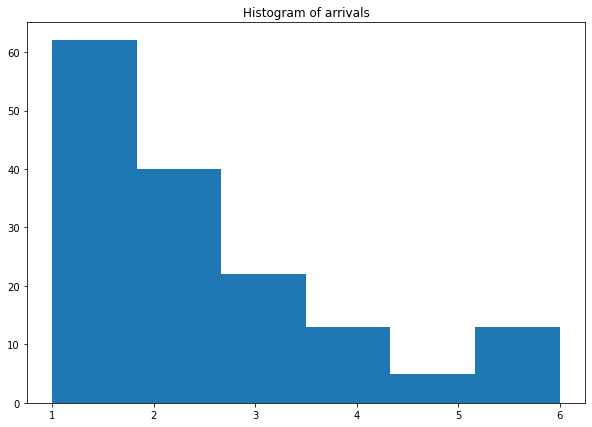

In [78]:
# round off arrivals
fig, ax = plt.subplots(figsize =(10, 7))
# mirror the arrivals to make it skewed for smaller arrivals compared to larger ones (can be removed if needed)
ax.hist([7-round(i) for i in arrival_rate],bins=6)
plt.title('Histogram of arrivals')